In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from functools import partial
import talib
from sklearn.metrics import accuracy_score
from tensorflow import keras

In [274]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperas import optim
from hyperas.distributions import choice, uniform

Using TensorFlow backend.


In [11]:
!pip install sklearn

     |████████████████████████████████| 10.2MB 3.1MB/s eta 0:00:01    |█████████▉                      | 3.1MB 1.0MB/s eta 0:00:08
  Using cached https://files.pythonhosted.org/packages/cd/c1/50a758e8247561e58cb87305b1e90b171b8c767b15b12a1734001f41d356/joblib-0.13.2-py2.py3-none-any.whl
     |████████████████████████████████| 27.6MB 3.0MB/s eta 0:00:01     |██████████████████████████████  | 25.8MB 5.3MB/s eta 0:00:01


In [273]:
!pip install hyperopt
!pip install hyperas

  Using cached https://files.pythonhosted.org/packages/63/12/704382c3081df3ae3f9d96fe6afb62efa2fa9749be20c301cd2797fb0b52/hyperopt-0.1.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/af/685bf3ce889ea191f3b916557f5677cc95a5e87b2fa120d74b5dd6d049d0/tqdm-4.32.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/90/52/e20466b85000a181e1e144fd8305caf2cf475e2f9674e797b222f8105f5f/future-0.17.1.tar.gz
     |████████████████████████████████| 358kB 904kB/s eta 0:00:01
  Stored in directory: /Users/guneykan/Library/Caches/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built future
  Using cached https://files.pythonhosted.org/packages/04/34/87ad6ffb42df9c1fa9c4c906f65813d42ad70d68c66af4ffff048c228cd4/hyperas-0.4.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://

  Stored in directory: /Users/guneykan/Library/Caches/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml


In [3]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 3.1MB/s ta 0:00:011
mkl-random 1.0.1 requires cython, which is not installed.
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1


In [13]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [2]:
start_date = '1970-12-31'
end_date = '2019-04-12'
df = web.DataReader('AAPL', 'yahoo', start_date, end_date)
df = df.drop(["Adj Close"], axis=1)
df["mid"] = (df["High"]+df["Low"])/2
df["return_log"] = df["mid"].pct_change(1)

In [3]:
df.head(10)

,High,Low,Open,Close,Volume,mid,return_log
Date,,,,,,,
1980-12-12,0.515625,0.513393,0.513393,0.513393,117258400.0,0.514509,NaN
1980-12-15,0.488839,0.486607,0.488839,0.486607,43971200.0,0.487723,-0.052061
1980-12-16,0.453125,0.450893,0.453125,0.450893,26432000.0,0.452009,-0.073227
1980-12-17,0.464286,0.462054,0.462054,0.462054,21610400.0,0.463170,0.024691
1980-12-18,0.477679,0.475446,0.475446,0.475446,18362400.0,0.476562,0.028916
1980-12-19,0.506696,0.504464,0.504464,0.504464,12157600.0,0.505580,0.060890
1980-12-22,0.531250,0.529018,0.529018,0.529018,9340800.0,0.530134,0.048565
1980-12-23,0.553571,0.551339,0.551339,0.551339,11737600.0,0.552455,0.042105
1980-12-24,0.582589,0.580357,0.580357,0.580357,12000800.0,0.581473,0.052525


In [4]:
# Smooth data with Double exponential moving average
df["Close"] = talib.DEMA(np.array(df["Close"]), timeperiod=3)
df["High"] = talib.DEMA(np.array(df["High"]), timeperiod=3)
df["Low"] = talib.DEMA(np.array(df["Low"]), timeperiod=3)
df["Open"] = talib.DEMA(np.array(df["Open"]), timeperiod=3)

In [5]:
df["dema"] = talib.DEMA(np.array(df["Close"]), timeperiod=30) #Double Exponential Moving Average
df["kama"] = talib.KAMA(np.array(df["Close"]), timeperiod=30) # Kaufman Adaptive Moving Average
df["trima"] = talib.TRIMA(np.array(df["Close"]), timeperiod=30) # Triple exponential
df["WMA"] = talib.WMA(np.array(df["Close"]), timeperiod=30) # Weighted moving average
df["adx"] = talib.ADX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["adxr"] = talib.ADXR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["apo"] = talib.APO(np.array(df["Close"]), fastperiod=12, slowperiod=26)
df["aroondown"], df["aroonup"] = talib.AROON(np.array(df["High"]), np.array(df["Low"]), timeperiod=14) 
df["aroonosc"] = talib.AROONOSC(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["bop"] = talib.BOP(np.array(df["Open"]), np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"])) 
df["cmo"] = talib.CMO(np.array(df["Close"]), timeperiod=14) 
df["dx"] = talib.DX(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["mfi"] = talib.MFI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), np.array(df["Volume"]), timeperiod=14) 
df["minus_di"] = talib.MINUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14) 
df["minus_dm"] = talib.MINUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["plus_di"] = talib.PLUS_DI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["plus_dm"] = talib.PLUS_DM(np.array(df["High"]), np.array(df["Low"]), timeperiod=14)
df["ppo"] = talib.PPO(np.array(df["Close"]), fastperiod=10, slowperiod=20)
df["rsi"] = talib.RSI(np.array(df["Close"]), timeperiod=14)
df["slowk"], df["slowd"] = talib.STOCH(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df["macd"], df["macdsignal"], df["macdhist"] = talib.MACD(np.array(df["Close"]), fastperiod=12, slowperiod=26, signalperiod=9)
df["cci"] = talib.CCI(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)
df["mom20"] = talib.MOM(np.array(df["Close"]), timeperiod=20)
df["mom10"] = talib.MOM(np.array(df["Close"]), timeperiod=10)
df["ma20"] = talib.SMA(np.array(df["Close"]), timeperiod=20)
df["ma10"] = talib.SMA(np.array(df["Close"]), timeperiod=10)
df["roc"] = talib.ROC(np.array(df["Close"]), timeperiod=10)
df["ult"] = talib.ULTOSC(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod1=7, timeperiod2=14, timeperiod3=28)
df["will"] = talib.WILLR(np.array(df["High"]), np.array(df["Low"]), np.array(df["Close"]), timeperiod=14)

In [ ]:
df["upperband"], df["middleband"], df["lowerband"] = talib.BBANDS(np.array(df["Close"]), timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df["hilbert"] = talib.HT_TRENDLINE(np.array(df["Close"]))

                                   

In [6]:
df.head(20)

,High,Low,Open,Close,Volume,mid,return_log,dema,kama,trima,...,macdsignal,macdhist,cci,mom20,mom10,ma20,ma10,roc,ult,will
Date,,,,,,,,,,,,,,,,,,,,,
1980-12-12,NaN,NaN,NaN,NaN,117258400.0,0.514509,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15,NaN,NaN,NaN,NaN,43971200.0,0.487723,-0.052061,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-16,NaN,NaN,NaN,NaN,26432000.0,0.452009,-0.073227,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-17,NaN,NaN,NaN,NaN,21610400.0,0.463170,0.024691,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-18,0.473648,0.471416,0.471292,0.471416,18362400.0,0.476562,0.028916,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-19,0.497752,0.495520,0.495365,0.495520,12157600.0,0.505580,0.060890,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-22,0.524430,0.522197,0.522073,0.522197,9340800.0,0.530134,0.048565,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-23,0.549545,0.547313,0.547228,0.547313,11737600.0,0.552455,0.042105,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-24,0.578594,0.576362,0.576307,0.576362,12000800.0,0.581473,0.052525,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df["return_1df"] = df["return_log"].shift(-1)
df = df.dropna()
df_ = df.copy()
df_ = df_.drop(["return_1df"], axis=1)

In [8]:
df.tail()

,High,Low,Open,Close,Volume,mid,return_log,dema,kama,trima,...,macdhist,cci,mom20,mom10,ma20,ma10,roc,ult,will,return_1df
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-05,197.265996,195.575126,196.220212,197.031482,18526600.0,196.514999,0.009037,193.759852,190.743735,184.175888,...,0.246490,140.127714,24.226734,4.715067,188.725600,191.601115,2.451724,70.014381,-4.968364,0.009007
2019-04-08,199.731579,196.520478,196.690401,199.626228,25881700.0,198.284996,0.009007,195.014138,192.113841,185.110959,...,0.398503,154.390872,22.376199,9.688483,189.844410,192.569964,5.100873,74.730365,-0.739076,0.013894
2019-04-09,202.437587,198.879195,199.665354,199.943355,35768200.0,201.040001,0.013894,196.170597,193.315479,186.039862,...,0.446746,159.652880,19.662007,12.362221,190.827510,193.806186,6.590333,68.410866,-14.722653,-0.007859
2019-04-10,201.634693,198.769072,199.342745,200.751794,21695300.0,199.459999,-0.007859,197.299303,194.467183,186.966904,...,0.457757,126.474375,18.955450,12.697592,191.775282,195.075945,6.752092,65.933528,-9.950695,0.001304
2019-04-11,201.405294,198.789279,200.723915,199.668455,20900800.0,199.720001,0.001304,198.166161,195.280531,187.863616,...,0.323081,98.216001,15.999955,11.204537,192.575280,196.196399,5.945189,62.190461,-16.345295,-0.007736


In [9]:
df_.tail()

,High,Low,Open,Close,Volume,mid,return_log,dema,kama,trima,...,macdsignal,macdhist,cci,mom20,mom10,ma20,ma10,roc,ult,will
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-05,197.265996,195.575126,196.220212,197.031482,18526600.0,196.514999,0.009037,193.759852,190.743735,184.175888,...,4.988015,0.246490,140.127714,24.226734,4.715067,188.725600,191.601115,2.451724,70.014381,-4.968364
2019-04-08,199.731579,196.520478,196.690401,199.626228,25881700.0,198.284996,0.009007,195.014138,192.113841,185.110959,...,5.087640,0.398503,154.390872,22.376199,9.688483,189.844410,192.569964,5.100873,74.730365,-0.739076
2019-04-09,202.437587,198.879195,199.665354,199.943355,35768200.0,201.040001,0.013894,196.170597,193.315479,186.039862,...,5.199327,0.446746,159.652880,19.662007,12.362221,190.827510,193.806186,6.590333,68.410866,-14.722653
2019-04-10,201.634693,198.769072,199.342745,200.751794,21695300.0,199.459999,-0.007859,197.299303,194.467183,186.966904,...,5.313766,0.457757,126.474375,18.955450,12.697592,191.775282,195.075945,6.752092,65.933528,-9.950695
2019-04-11,201.405294,198.789279,200.723915,199.668455,20900800.0,199.720001,0.001304,198.166161,195.280531,187.863616,...,5.394536,0.323081,98.216001,15.999955,11.204537,192.575280,196.196399,5.945189,62.190461,-16.345295


In [10]:
pd.options.display.max_rows = 300
pd.options.display.max_columns = 300

In [11]:
train_df_ = df_.iloc[:9000]
test_df_ = df_.iloc[9000:9200]
train_df = df.iloc[:9000]
test_df = df.iloc[9000:9200]
out_of_sample = df.iloc[9200:9500]
out_of_sample_ = df_.iloc[9200:9500]

In [12]:
train_data_X = np.array(train_df_.values)
train_data_y = np.array(train_df["return_1df"].values)
test_data_X = np.array(test_df_.values)
test_data_y = np.array(test_df["return_1df"].values)
X_out_sample = np.array(out_of_sample_.values)
y_out_sample = np.array(out_of_sample["return_1df"].values)

In [13]:
smoothing_window_size = 600
scaler_min = MinMaxScaler()
for di in range(0,9000,smoothing_window_size):
    scaler_min.fit(train_data_X[di:di+smoothing_window_size,:])
    train_data_X[di:di+smoothing_window_size,:] = scaler_min.transform(train_data_X[di:di+smoothing_window_size,:])

In [14]:
test_data_X = scaler_min.transform(test_data_X)
X_out_sample = scaler_min.transform(X_out_sample)

In [51]:
X_train = train_data_X
y_train = train_data_y
X_valid = test_data_X
y_valid = test_data_y
X_test = X_out_sample
y_test = y_out_sample

In [106]:
# LSTM autoencoders perform poorly
np.random.seed(42)
tf.random.set_seed(42)
input = keras.layers.Input(shape=[n_steps, num_features])
encoder = keras.layers.LSTM(num_encoder, return_sequences=True)(input)
encoder1 = keras.layers.LSTM(num_encoder1, return_sequences=True)(encoder)
encoder2 = keras.layers.LSTM(num_encoder2, return_sequences=True)(encoder1)
encoded = keras.layers.LSTM(num_encoded)(encoder2)
repeat = keras.layers.RepeatVector(n_steps, input_shape=[num_encoded])(encoded)
decoder = keras.layers.LSTM(num_decoder, return_sequences=True)(repeat)
decoder1 = keras.layers.LSTM(num_decoder1, return_sequences=True)(decoder)
decoder2 = keras.layers.LSTM(num_decoder2, return_sequences=True)(decoder1)
decoded = keras.layers.TimeDistributed(keras.layers.Dense(num_features, activation="sigmoid"))(decoder2)
ae_model = keras.models.Model(inputs=[input], outputs=[decoded])
encode_model = keras.models.Model(inputs=[input], outputs=[encoded])

In [107]:
ae_model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 20, 40)]          0         
_________________________________________________________________
unified_lstm_41 (UnifiedLSTM (None, 20, 100)           56400     
_________________________________________________________________
unified_lstm_42 (UnifiedLSTM (None, 20, 80)            57920     
_________________________________________________________________
unified_lstm_43 (UnifiedLSTM (None, 20, 40)            19360     
_________________________________________________________________
unified_lstm_44 (UnifiedLSTM (None, 20)                4880      
_________________________________________________________________
repeat_vector_13 (RepeatVect (None, 20, 20)            0         
_________________________________________________________________
unified_lstm_45 (UnifiedLSTM (None, 20, 40)            976

In [108]:
X_train = X_train.reshape((-1, n_steps, num_features))
X_valid = X_valid.reshape((-1, n_steps, num_features))
X_test = X_test.reshape((-1, n_steps, num_features))

In [109]:
early_stop = keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)
ae_model.compile(loss="mse", optimizer="nadam")
history = ae_model.fit(X_train, X_train, epochs=2000, validation_data=[X_valid, X_valid], callbacks=[early_stop])

Train on 450 samples, validate on 10 samples
Epoch 1/2000
450/450 [==============================] - 4s 9ms/sample - loss: 0.0661 - val_loss: 0.2217
Epoch 2/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0533 - val_loss: 0.1787
Epoch 3/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0491 - val_loss: 0.1583
Epoch 4/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0457 - val_loss: 0.1518
Epoch 5/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0432 - val_loss: 0.1470
Epoch 6/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0387 - val_loss: 0.1748
Epoch 7/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0390 - val_loss: 0.1499
Epoch 8/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0345 - val_loss: 0.1291
Epoch 9/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0326 - val_loss: 0.1169
Epoch 10/2000
450/4

450/450 [==============================] - 1s 3ms/sample - loss: 0.0105 - val_loss: 0.0765
Epoch 156/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0107 - val_loss: 0.0720
Epoch 157/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0100 - val_loss: 0.1035
Epoch 158/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0155 - val_loss: 0.0723
Epoch 159/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0108 - val_loss: 0.0697
Epoch 160/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0103 - val_loss: 0.0705
Epoch 161/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0100 - val_loss: 0.0699
Epoch 162/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0100 - val_loss: 0.0708
Epoch 163/2000
450/450 [==============================] - 1s 3ms/sample - loss: 0.0099 - val_loss: 0.0700
Epoch 164/2000
450/450 [==============================] - 1s 

In [27]:
class AutoEncoder:
    def __init__(self, pool):
        self.pool = pool

    def build_train_model(self, input_shape, encoded1_shape, encoded2_shape, decoded1_shape, decoded2_shape):
        input_data = keras.layers.Input(shape=(20, input_shape)) # 20 dims
        normalize = keras.layers.BatchNormalization()(input_data)
        encoded1 = keras.layers.Conv1D(encoded1_shape, 3, padding = "same", activation="selu")(normalize) #20 dims
        pool0 = keras.layers.MaxPool1D(pool)(encoded1) # 10 dims
        encoded2 = keras.layers.Conv1D(encoded2_shape, 3, padding = "same", activation="selu")(pool0) # 10 dims
        pool1 = keras.layers.MaxPool1D(pool)(encoded2) # 5 dims, encoded data, upsample from here
        decoded1 = keras.layers.Conv1D(decoded1_shape, 3, padding = "same", activation="selu")(pool1) # 5 dims
        upsample0 = keras.layers.UpSampling1D(pool)(decoded1) # 10 dims
        decoded2 = keras.layers.Conv1D(decoded2_shape, 3, padding = "same", activation="selu")(upsample0) # 10 dims
        upsample1 = keras.layers.UpSampling1D(pool)(decoded2) # 20 dims
        output_data = keras.layers.Conv1D(input_shape, 3, padding = "same", activation="sigmoid")(upsample1)
        
        
        
        autoencoder = keras.models.Model(inputs=input_data, outputs=output_data)

        encoder = keras.models.Model(input_data, pool1)
        autoencoder.compile(loss="mean_squared_error", optimizer="Nadam")

        train = train_data_X
        ntrain = np.array(train)
        train_data = np.reshape(ntrain, (-1, 20, input_shape))
        
        test = test_data_X
        ntest = np.array(test)
        test_data = np.reshape(ntest, (-1, 20, input_shape))
        
        out_sample = X_out_sample
        nout = np.array(out_sample)
        out_data = np.reshape(nout, (len(-1, 20, input_shape))

        autoencoder.fit(train_data, train_data, epochs=1000)
        valid_error = autoencoder.evaluate(test_data, test_data)
        test_error = autoencoder.evaluate(out_data, out_data)

        
    
        coded_train = encoder.predict(train_data)
        coded_test = encoder.predict(test_data)        
        coded_outsample = encoder.predict(out_data)
        return train_coded, test_coded, out_coded

SyntaxError: invalid syntax (<ipython-input-27-572139793b36>, line 37)

In [31]:
input_data = keras.layers.Input(shape=(20, 40))
normalize = keras.layers.BatchNormalization()(input_data)
encoded1 = keras.layers.Conv1D(80, 3, padding = "same", activation="selu")(normalize) #20 dims
pool0 = keras.layers.MaxPool1D(2)(encoded1) # 10 dims
encoded2 = keras.layers.Conv1D(40, 3, padding = "same", activation="selu")(pool0) # 10 dims
pool1 = keras.layers.MaxPool1D(2)(encoded2) # 5 dims, encoded data, upsample from here
decoded1 = keras.layers.Conv1D(40, 3, padding = "same", activation="selu")(pool1) # 5 dims
upsample0 = keras.layers.UpSampling1D(2)(decoded1) # 10 dims
decoded2 = keras.layers.Conv1D(80, 3, padding = "same", activation="selu")(upsample0) # 10 dims
upsample1 = keras.layers.UpSampling1D(2)(decoded2) # 20 dims
output_data = keras.layers.Conv1D(40, 3, padding = "same", activation="sigmoid")(upsample1)
autoencoder = keras.models.Model(inputs=input_data, outputs=output_data)
encoder = keras.models.Model(input_data, pool1)
autoencoder.compile(loss="mean_squared_error", optimizer="Nadam")

In [33]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 20, 40)]          0         
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 20, 40)            160       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 20, 80)            9680      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 10, 80)            0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 10, 40)            9640      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 5, 40)             0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 5, 40)             4840  

In [37]:
autoencoder.fit(X_train, X_train, epochs=1000)

Epoch 1/1000
450/450 [==============================] - 1s 1ms/sample - loss: 0.0542
Epoch 2/1000
450/450 [==============================] - 0s 257us/sample - loss: 0.0227
Epoch 3/1000
450/450 [==============================] - 0s 250us/sample - loss: 0.0185
Epoch 4/1000
450/450 [==============================] - 0s 247us/sample - loss: 0.0150
Epoch 5/1000
450/450 [==============================] - 0s 242us/sample - loss: 0.0147
Epoch 6/1000
450/450 [==============================] - 0s 249us/sample - loss: 0.0127
Epoch 7/1000
450/450 [==============================] - 0s 252us/sample - loss: 0.0129
Epoch 8/1000
450/450 [==============================] - 0s 239us/sample - loss: 0.0126
Epoch 9/1000
450/450 [==============================] - 0s 237us/sample - loss: 0.0122
Epoch 10/1000
450/450 [==============================] - 0s 228us/sample - loss: 0.0116
Epoch 11/1000
450/450 [==============================] - 0s 240us/sample - loss: 0.0116
Epoch 12/1000
450/450 [====================

450/450 [==============================] - 0s 255us/sample - loss: 0.0062
Epoch 95/1000
450/450 [==============================] - 0s 235us/sample - loss: 0.0069
Epoch 96/1000
450/450 [==============================] - 0s 221us/sample - loss: 0.0064
Epoch 97/1000
450/450 [==============================] - 0s 213us/sample - loss: 0.0055
Epoch 98/1000
450/450 [==============================] - 0s 218us/sample - loss: 0.0058
Epoch 99/1000
450/450 [==============================] - 0s 237us/sample - loss: 0.0055
Epoch 100/1000
450/450 [==============================] - 0s 231us/sample - loss: 0.0061
Epoch 101/1000
450/450 [==============================] - 0s 231us/sample - loss: 0.0061
Epoch 102/1000
450/450 [==============================] - 0s 226us/sample - loss: 0.0065
Epoch 103/1000
450/450 [==============================] - 0s 227us/sample - loss: 0.0057
Epoch 104/1000
450/450 [==============================] - 0s 219us/sample - loss: 0.0058
Epoch 105/1000
450/450 [=================

450/450 [==============================] - 0s 209us/sample - loss: 0.0052
Epoch 187/1000
450/450 [==============================] - 0s 213us/sample - loss: 0.0047
Epoch 188/1000
450/450 [==============================] - 0s 203us/sample - loss: 0.0048
Epoch 189/1000
450/450 [==============================] - 0s 214us/sample - loss: 0.0061
Epoch 190/1000
450/450 [==============================] - 0s 206us/sample - loss: 0.0054
Epoch 191/1000
450/450 [==============================] - 0s 205us/sample - loss: 0.0062
Epoch 192/1000
450/450 [==============================] - 0s 201us/sample - loss: 0.0050
Epoch 193/1000
450/450 [==============================] - 0s 202us/sample - loss: 0.0057
Epoch 194/1000
450/450 [==============================] - 0s 207us/sample - loss: 0.0059
Epoch 195/1000
450/450 [==============================] - 0s 233us/sample - loss: 0.0056
Epoch 196/1000
450/450 [==============================] - 0s 211us/sample - loss: 0.0051
Epoch 197/1000
450/450 [============

450/450 [==============================] - 0s 201us/sample - loss: 0.0044
Epoch 279/1000
450/450 [==============================] - 0s 197us/sample - loss: 0.0057
Epoch 280/1000
450/450 [==============================] - 0s 184us/sample - loss: 0.0051
Epoch 281/1000
450/450 [==============================] - 0s 182us/sample - loss: 0.0048
Epoch 282/1000
450/450 [==============================] - 0s 186us/sample - loss: 0.0046
Epoch 283/1000
450/450 [==============================] - 0s 183us/sample - loss: 0.0049
Epoch 284/1000
450/450 [==============================] - 0s 186us/sample - loss: 0.0048
Epoch 285/1000
450/450 [==============================] - 0s 188us/sample - loss: 0.0053
Epoch 286/1000
450/450 [==============================] - 0s 188us/sample - loss: 0.0048
Epoch 287/1000
450/450 [==============================] - 0s 183us/sample - loss: 0.0048
Epoch 288/1000
450/450 [==============================] - 0s 183us/sample - loss: 0.0045
Epoch 289/1000
450/450 [============

450/450 [==============================] - 0s 203us/sample - loss: 0.0044
Epoch 371/1000
450/450 [==============================] - 0s 189us/sample - loss: 0.0047
Epoch 372/1000
450/450 [==============================] - 0s 181us/sample - loss: 0.0045
Epoch 373/1000
450/450 [==============================] - 0s 187us/sample - loss: 0.0040
Epoch 374/1000
450/450 [==============================] - 0s 193us/sample - loss: 0.0045
Epoch 375/1000
450/450 [==============================] - 0s 196us/sample - loss: 0.0045
Epoch 376/1000
450/450 [==============================] - 0s 196us/sample - loss: 0.0047
Epoch 377/1000
450/450 [==============================] - 0s 184us/sample - loss: 0.0041
Epoch 378/1000
450/450 [==============================] - 0s 188us/sample - loss: 0.0052
Epoch 379/1000
450/450 [==============================] - 0s 185us/sample - loss: 0.0050
Epoch 380/1000
450/450 [==============================] - 0s 195us/sample - loss: 0.0043
Epoch 381/1000
450/450 [============

450/450 [==============================] - 0s 207us/sample - loss: 0.0045
Epoch 463/1000
450/450 [==============================] - 0s 194us/sample - loss: 0.0041
Epoch 464/1000
450/450 [==============================] - 0s 183us/sample - loss: 0.0041
Epoch 465/1000
450/450 [==============================] - 0s 183us/sample - loss: 0.0044
Epoch 466/1000
450/450 [==============================] - 0s 186us/sample - loss: 0.0039
Epoch 467/1000
450/450 [==============================] - 0s 186us/sample - loss: 0.0046
Epoch 468/1000
450/450 [==============================] - 0s 187us/sample - loss: 0.0041
Epoch 469/1000
450/450 [==============================] - 0s 185us/sample - loss: 0.0050
Epoch 470/1000
450/450 [==============================] - 0s 189us/sample - loss: 0.0044
Epoch 471/1000
450/450 [==============================] - 0s 187us/sample - loss: 0.0046
Epoch 472/1000
450/450 [==============================] - 0s 191us/sample - loss: 0.0050
Epoch 473/1000
450/450 [============

450/450 [==============================] - 0s 212us/sample - loss: 0.0037
Epoch 555/1000
450/450 [==============================] - 0s 194us/sample - loss: 0.0034
Epoch 556/1000
450/450 [==============================] - 0s 187us/sample - loss: 0.0044
Epoch 557/1000
450/450 [==============================] - 0s 186us/sample - loss: 0.0045
Epoch 558/1000
450/450 [==============================] - 0s 192us/sample - loss: 0.0039
Epoch 559/1000
450/450 [==============================] - 0s 196us/sample - loss: 0.0040
Epoch 560/1000
450/450 [==============================] - 0s 186us/sample - loss: 0.0037
Epoch 561/1000
450/450 [==============================] - 0s 193us/sample - loss: 0.0036
Epoch 562/1000
450/450 [==============================] - 0s 196us/sample - loss: 0.0038
Epoch 563/1000
450/450 [==============================] - 0s 194us/sample - loss: 0.0041
Epoch 564/1000
450/450 [==============================] - 0s 185us/sample - loss: 0.0039
Epoch 565/1000
450/450 [============

450/450 [==============================] - 0s 228us/sample - loss: 0.0041
Epoch 647/1000
450/450 [==============================] - 0s 224us/sample - loss: 0.0044
Epoch 648/1000
450/450 [==============================] - 0s 228us/sample - loss: 0.0038
Epoch 649/1000
450/450 [==============================] - 0s 220us/sample - loss: 0.0041
Epoch 650/1000
450/450 [==============================] - 0s 215us/sample - loss: 0.0045
Epoch 651/1000
450/450 [==============================] - 0s 208us/sample - loss: 0.0039
Epoch 652/1000
450/450 [==============================] - 0s 199us/sample - loss: 0.0037
Epoch 653/1000
450/450 [==============================] - 0s 208us/sample - loss: 0.0036
Epoch 654/1000
450/450 [==============================] - 0s 196us/sample - loss: 0.0038
Epoch 655/1000
450/450 [==============================] - 0s 199us/sample - loss: 0.0041
Epoch 656/1000
450/450 [==============================] - 0s 224us/sample - loss: 0.0036
Epoch 657/1000
450/450 [============

450/450 [==============================] - 0s 229us/sample - loss: 0.0039
Epoch 739/1000
450/450 [==============================] - 0s 233us/sample - loss: 0.0035
Epoch 740/1000
450/450 [==============================] - 0s 217us/sample - loss: 0.0037
Epoch 741/1000
450/450 [==============================] - 0s 213us/sample - loss: 0.0041
Epoch 742/1000
450/450 [==============================] - 0s 213us/sample - loss: 0.0045
Epoch 743/1000
450/450 [==============================] - 0s 217us/sample - loss: 0.0040
Epoch 744/1000
450/450 [==============================] - 0s 208us/sample - loss: 0.0042
Epoch 745/1000
450/450 [==============================] - 0s 203us/sample - loss: 0.0040
Epoch 746/1000
450/450 [==============================] - 0s 207us/sample - loss: 0.0040
Epoch 747/1000
450/450 [==============================] - 0s 208us/sample - loss: 0.0038
Epoch 748/1000
450/450 [==============================] - 0s 202us/sample - loss: 0.0040
Epoch 749/1000
450/450 [============

450/450 [==============================] - 0s 240us/sample - loss: 0.0032
Epoch 831/1000
450/450 [==============================] - 0s 243us/sample - loss: 0.0034
Epoch 832/1000
450/450 [==============================] - 0s 240us/sample - loss: 0.0037
Epoch 833/1000
450/450 [==============================] - 0s 229us/sample - loss: 0.0034
Epoch 834/1000
450/450 [==============================] - 0s 231us/sample - loss: 0.0037
Epoch 835/1000
450/450 [==============================] - 0s 237us/sample - loss: 0.0034
Epoch 836/1000
450/450 [==============================] - 0s 230us/sample - loss: 0.0040
Epoch 837/1000
450/450 [==============================] - 0s 236us/sample - loss: 0.0038
Epoch 838/1000
450/450 [==============================] - 0s 235us/sample - loss: 0.0038
Epoch 839/1000
450/450 [==============================] - 0s 238us/sample - loss: 0.0033
Epoch 840/1000
450/450 [==============================] - 0s 241us/sample - loss: 0.0037
Epoch 841/1000
450/450 [============

450/450 [==============================] - 0s 239us/sample - loss: 0.0041
Epoch 923/1000
450/450 [==============================] - 0s 237us/sample - loss: 0.0036
Epoch 924/1000
450/450 [==============================] - 0s 221us/sample - loss: 0.0039
Epoch 925/1000
450/450 [==============================] - 0s 226us/sample - loss: 0.0035
Epoch 926/1000
450/450 [==============================] - 0s 219us/sample - loss: 0.0042
Epoch 927/1000
450/450 [==============================] - 0s 219us/sample - loss: 0.0036
Epoch 928/1000
450/450 [==============================] - 0s 220us/sample - loss: 0.0036
Epoch 929/1000
450/450 [==============================] - 0s 229us/sample - loss: 0.0043
Epoch 930/1000
450/450 [==============================] - 0s 234us/sample - loss: 0.0037
Epoch 931/1000
450/450 [==============================] - 0s 229us/sample - loss: 0.0042
Epoch 932/1000
450/450 [==============================] - 0s 226us/sample - loss: 0.0040
Epoch 933/1000
450/450 [============

In [52]:
X_train = X_train.reshape(-1, 20, 40)
X_valid = X_valid.reshape(-1, 20, 40)
X_test = X_test.reshape(-1, 20, 40)

In [53]:
X_train_coded = encoder.predict(X_train)
X_valid_coded = encoder.predict(X_valid)        
X_test_coded = encoder.predict(X_test)

In [54]:
X_train_coded = X_train_coded.reshape(9000, -1)
X_valid_coded = X_valid_coded.reshape(200, -1)
X_test_coded = X_test_coded.reshape(300, -1)

(9000, 10)

In [49]:
def nn(n_hidden=2, nodes=30, input_shape=X_train_coded.shape[1:], activation="selu", rate=0.2, optimizer="Nadam"):
    model = keras.models.Sequential()
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(nodes, input_shape=input_shape))
    if activation == "selu":
        initializer = "lecun_normal"
    else:
        initializer = "he_normal"
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(nodes,  kernel_initializer=initializer, activation=activation))
    if activation == "selu":
        model.add(MCAlphaDropout(rate=rate))
    else:
        model.add(MCDropout(rate=rate))
    model.add(keras.layers.Dense(1, activation="tanh"))
    model.compile(loss="mse", optimizer=optimizer)
    #early_stp = keras.callbacks.EarlyStopping(patience=60, restore_best_weights=True)
    #history = model.fit(X_train_enc_, y_train, epochs=1000, batch_size=params['batch_size'], callbacks=[early_stp], validation_data=[X_valid_enc_, y_valid])
    #y_pred  = model.predict(X_valid_enc_)
    #loss = mean_squared_error(y_valid, y_pred)
    return model
    
space = {"nodes": [10, 20, 30, 40, 50, 100, 150, 200, 250, 300, 500], 
        "activation": ["selu", "elu", "relu"], 
        "rate": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6], 
        "optimizer": ["RMSprop", "Adam", "Nadam"],  
        "n_hidden": [1, 2, 3, 4, 5, 6]}
    

In [50]:
nn_reg = keras.wrappers.scikit_learn.KerasRegressor(nn)

In [58]:
nn_reg.fit(X_train_coded, y_train, epochs=1000, validation_data=(X_valid_coded, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=100)])

Train on 9000 samples, validate on 200 samples
Epoch 1/1000
9000/9000 [==============================] - 1s 116us/sample - loss: 0.1642 - val_loss: 0.0314
Epoch 2/1000
9000/9000 [==============================] - 1s 59us/sample - loss: 0.0100 - val_loss: 0.0041
Epoch 3/1000
9000/9000 [==============================] - 1s 59us/sample - loss: 0.0027 - val_loss: 0.0012
Epoch 4/1000
9000/9000 [==============================] - 1s 59us/sample - loss: 0.0015 - val_loss: 0.0011
Epoch 5/1000
9000/9000 [==============================] - 1s 59us/sample - loss: 0.0011 - val_loss: 6.3306e-04
Epoch 6/1000
9000/9000 [==============================] - 1s 59us/sample - loss: 9.4686e-04 - val_loss: 0.0011
Epoch 7/1000
9000/9000 [==============================] - 1s 61us/sample - loss: 8.7301e-04 - val_loss: 7.2160e-04
Epoch 8/1000
9000/9000 [==============================] - 1s 60us/sample - loss: 8.0676e-04 - val_loss: 3.4990e-04
Epoch 9/1000
9000/9000 [==============================] - 1s 59us/sample

9000/9000 [==============================] - 1s 61us/sample - loss: 6.3548e-04 - val_loss: 7.3693e-04
Epoch 72/1000
9000/9000 [==============================] - 1s 60us/sample - loss: 6.3067e-04 - val_loss: 6.1682e-04
Epoch 73/1000
9000/9000 [==============================] - 1s 61us/sample - loss: 6.7942e-04 - val_loss: 1.1483e-04
Epoch 74/1000
9000/9000 [==============================] - 1s 59us/sample - loss: 6.4248e-04 - val_loss: 2.4594e-04
Epoch 75/1000
9000/9000 [==============================] - 1s 58us/sample - loss: 6.3669e-04 - val_loss: 1.7968e-04
Epoch 76/1000
9000/9000 [==============================] - 1s 57us/sample - loss: 6.3366e-04 - val_loss: 3.3805e-04
Epoch 77/1000
9000/9000 [==============================] - 0s 53us/sample - loss: 6.3047e-04 - val_loss: 3.4295e-04
Epoch 78/1000
9000/9000 [==============================] - 0s 53us/sample - loss: 6.3068e-04 - val_loss: 2.2144e-04
Epoch 79/1000
9000/9000 [==============================] - 1s 58us/sample - loss: 6.41

In [307]:
from sklearn.model_selection import RandomizedSearchCV

In [2]:
rnd_search_cv = RandomizedSearchCV(nn_reg, space, n_iter=100, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=1000, validation_data=(X_valid, y_valid), 
                  callbacks=[keras.callbacks.EarlyStopping(patience=50)])

NameError: name 'RandomizedSearchCV' is not defined

In [1]:
rnd_search_cv.best_score_

NameError: name 'rnd_search_cv' is not defined

In [302]:
mse_test = keras_reg.score(X_valid_enc_, y_valid)

200/200 [==============================] - 0s 75us/sample - loss: 1.8187e-04


In [56]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [309]:
np.random.seed(42)
tf.random.set_seed(42)
if __name__ == "__main__":
    autoencoder = AutoEncoder(15)
    X_train_enc, X_valid_enc, X_test_enc, valid_error_, test_error_ = autoencoder.build_train_model(40, 30, 20, 20, 30)

Train on 9000 samples, validate on 200 samples
Epoch 1/1000
9000/9000 [==============================] - 5s 582us/sample - loss: 0.0231 - val_loss: 0.0807
Epoch 2/1000
9000/9000 [==============================] - 2s 259us/sample - loss: 0.0093 - val_loss: 0.0653
Epoch 3/1000
9000/9000 [==============================] - 2s 228us/sample - loss: 0.0073 - val_loss: 0.0621
Epoch 4/1000
9000/9000 [==============================] - 2s 210us/sample - loss: 0.0065 - val_loss: 0.0600
Epoch 5/1000
9000/9000 [==============================] - 2s 197us/sample - loss: 0.0060 - val_loss: 0.0590
Epoch 6/1000
9000/9000 [==============================] - 2s 202us/sample - loss: 0.0057 - val_loss: 0.0584
Epoch 7/1000
9000/9000 [==============================] - 2s 195us/sample - loss: 0.0054 - val_loss: 0.0557
Epoch 8/1000
9000/9000 [==============================] - 2s 213us/sample - loss: 0.0051 - val_loss: 0.0583
Epoch 9/1000
9000/9000 [==============================] - 2s 194us/sample - loss: 0.0050 

Epoch 76/1000
9000/9000 [==============================] - 2s 186us/sample - loss: 0.0038 - val_loss: 0.0495
Epoch 77/1000
9000/9000 [==============================] - 2s 188us/sample - loss: 0.0038 - val_loss: 0.0494
Epoch 78/1000
9000/9000 [==============================] - 2s 187us/sample - loss: 0.0037 - val_loss: 0.0487
Epoch 79/1000
9000/9000 [==============================] - 2s 189us/sample - loss: 0.0039 - val_loss: 0.0491
Epoch 80/1000
9000/9000 [==============================] - 2s 203us/sample - loss: 0.0038 - val_loss: 0.0504
Epoch 81/1000
9000/9000 [==============================] - 2s 197us/sample - loss: 0.0038 - val_loss: 0.0495
Epoch 82/1000
9000/9000 [==============================] - 2s 199us/sample - loss: 0.0037 - val_loss: 0.0489
Epoch 83/1000
9000/9000 [==============================] - 2s 185us/sample - loss: 0.0038 - val_loss: 0.0491
Epoch 84/1000
9000/9000 [==============================] - 2s 187us/sample - loss: 0.0039 - val_loss: 0.0496
Epoch 85/1000
9000/

9000/9000 [==============================] - 2s 179us/sample - loss: 0.0034 - val_loss: 0.0502
Epoch 225/1000
9000/9000 [==============================] - 2s 179us/sample - loss: 0.0035 - val_loss: 0.0505
Epoch 226/1000
9000/9000 [==============================] - 2s 178us/sample - loss: 0.0035 - val_loss: 0.0493
Epoch 227/1000
9000/9000 [==============================] - 2s 179us/sample - loss: 0.0035 - val_loss: 0.0500
Epoch 228/1000
9000/9000 [==============================] - 2s 180us/sample - loss: 0.0034 - val_loss: 0.0491
Epoch 229/1000
9000/9000 [==============================] - 2s 178us/sample - loss: 0.0035 - val_loss: 0.0501
Epoch 230/1000
9000/9000 [==============================] - 2s 180us/sample - loss: 0.0035 - val_loss: 0.0499
Epoch 231/1000
9000/9000 [==============================] - 2s 179us/sample - loss: 0.0035 - val_loss: 0.0499
Epoch 232/1000
9000/9000 [==============================] - 2s 181us/sample - loss: 0.0034 - val_loss: 0.0499
Epoch 233/1000
9000/9000 

9000/9000 [==============================] - 2s 183us/sample - loss: 0.0033 - val_loss: 0.0499
Epoch 373/1000
9000/9000 [==============================] - 2s 187us/sample - loss: 0.0033 - val_loss: 0.0504
Epoch 374/1000
9000/9000 [==============================] - 2s 184us/sample - loss: 0.0033 - val_loss: 0.0499
Epoch 375/1000
9000/9000 [==============================] - 2s 186us/sample - loss: 0.0034 - val_loss: 0.0496
Epoch 376/1000
9000/9000 [==============================] - 2s 186us/sample - loss: 0.0034 - val_loss: 0.0502
Epoch 377/1000
9000/9000 [==============================] - 2s 181us/sample - loss: 0.0033 - val_loss: 0.0493
Epoch 378/1000
9000/9000 [==============================] - 2s 176us/sample - loss: 0.0033 - val_loss: 0.0503
Epoch 379/1000
9000/9000 [==============================] - 2s 173us/sample - loss: 0.0032 - val_loss: 0.0504
Epoch 380/1000
9000/9000 [==============================] - 2s 174us/sample - loss: 0.0032 - val_loss: 0.0499
Epoch 381/1000
9000/9000 

9000/9000 [==============================] - 2s 185us/sample - loss: 0.0032 - val_loss: 0.0490
Epoch 521/1000
9000/9000 [==============================] - 2s 185us/sample - loss: 0.0032 - val_loss: 0.0492
Epoch 522/1000
9000/9000 [==============================] - 2s 185us/sample - loss: 0.0032 - val_loss: 0.0503
Epoch 523/1000
9000/9000 [==============================] - 2s 183us/sample - loss: 0.0033 - val_loss: 0.0492
Epoch 524/1000
9000/9000 [==============================] - 2s 182us/sample - loss: 0.0033 - val_loss: 0.0503
Epoch 525/1000
9000/9000 [==============================] - 2s 185us/sample - loss: 0.0032 - val_loss: 0.0499
Epoch 526/1000
9000/9000 [==============================] - 2s 185us/sample - loss: 0.0032 - val_loss: 0.0497
Epoch 527/1000
9000/9000 [==============================] - 2s 185us/sample - loss: 0.0032 - val_loss: 0.0492
Epoch 528/1000
9000/9000 [==============================] - 2s 182us/sample - loss: 0.0034 - val_loss: 0.0492
Epoch 529/1000
9000/9000 

In [310]:
# Valid error with he_init and elu activation
valid_error_

0.04854849748313427

In [311]:
# Valid error with lecun and selu activation
test_error_

0.5899068768819173

In [312]:
X_train_enc_ = X_train_enc.values
X_valid_enc_ = X_valid_enc.values
X_test_enc_ = X_test_enc.values

In [1]:
X_train_enc_.shape

NameError: name 'X_train_enc_' is not defined

In [57]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [266]:
encoded_input = keras.layers.Input(shape=X_train_enc_.shape[1:])
normalize0 = keras.layers.BatchNormalization()(encoded_input)
hidden0 = keras.layers.Dense(20, kernel_initializer="lecun_normal", activation="selu")(normalize0)
hidden1 = keras.layers.Dense(20, kernel_initializer="lecun_normal", activation="selu")(hidden0)
#hidden2 = keras.layers.Dense(100, kernel_initializer="lecun_normal", activation="selu")(hidden1)
#hidden3 = keras.layers.Dense(50, kernel_initializer="lecun_normal", activation="selu")(hidden2)
#hidden4 = keras.layers.Dense(20, kernel_initializer="lecun_normal", activation="selu")(hidden3)
#dropout = MCAlphaDropout(rate=0.2)(hidden4)
output = keras.layers.Dense(1, activation="tanh")(hidden1)
mlp = keras.models.Model(inputs=[encoded_input], outputs=[output])
early_stp = keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)
mlp.compile(loss="mse", optimizer="nadam")


In [267]:
mlp.summary()

Model: "model_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
batch_normalization_v2_21 (B (None, 20)                80        
_________________________________________________________________
dense_123 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_124 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 21        
Total params: 941
Trainable params: 901
Non-trainable params: 40
_________________________________________________________________


In [268]:
history = mlp.fit(X_train_enc_, y_train, epochs=1000, callbacks=[early_stp], validation_data=[X_valid_enc_, y_valid])

Train on 9000 samples, validate on 200 samples
Epoch 1/1000
9000/9000 [==============================] - 1s 128us/sample - loss: 0.0667 - val_loss: 0.0161
Epoch 2/1000
9000/9000 [==============================] - 1s 62us/sample - loss: 0.0086 - val_loss: 0.0185
Epoch 3/1000
9000/9000 [==============================] - 1s 61us/sample - loss: 0.0048 - val_loss: 0.0170
Epoch 4/1000
9000/9000 [==============================] - 1s 61us/sample - loss: 0.0034 - val_loss: 0.0074
Epoch 5/1000
9000/9000 [==============================] - 1s 60us/sample - loss: 0.0026 - val_loss: 0.0070
Epoch 6/1000
9000/9000 [==============================] - 1s 59us/sample - loss: 0.0022 - val_loss: 0.0057
Epoch 7/1000
9000/9000 [==============================] - 1s 60us/sample - loss: 0.0019 - val_loss: 0.0052
Epoch 8/1000
9000/9000 [==============================] - 1s 60us/sample - loss: 0.0017 - val_loss: 0.0042
Epoch 9/1000
9000/9000 [==============================] - 1s 58us/sample - loss: 0.0015 - val_lo

9000/9000 [==============================] - 0s 53us/sample - loss: 5.2921e-04 - val_loss: 1.2479e-04
Epoch 143/1000
9000/9000 [==============================] - 0s 50us/sample - loss: 5.3316e-04 - val_loss: 1.0799e-04
Epoch 144/1000
9000/9000 [==============================] - 0s 50us/sample - loss: 5.2687e-04 - val_loss: 1.1267e-04
Epoch 145/1000
9000/9000 [==============================] - 0s 50us/sample - loss: 5.3033e-04 - val_loss: 1.0526e-04
Epoch 146/1000
9000/9000 [==============================] - 0s 50us/sample - loss: 5.2766e-04 - val_loss: 1.4467e-04
Epoch 147/1000
9000/9000 [==============================] - 0s 50us/sample - loss: 5.2764e-04 - val_loss: 1.1727e-04
Epoch 148/1000
9000/9000 [==============================] - 0s 50us/sample - loss: 5.3347e-04 - val_loss: 1.5545e-04
Epoch 149/1000
9000/9000 [==============================] - 0s 50us/sample - loss: 5.3379e-04 - val_loss: 1.0702e-04
Epoch 150/1000
9000/9000 [==============================] - 0s 50us/sample - lo

9000/9000 [==============================] - 1s 102us/sample - loss: 5.2663e-04 - val_loss: 1.0888e-04
Epoch 283/1000
9000/9000 [==============================] - 1s 90us/sample - loss: 5.2309e-04 - val_loss: 1.3297e-04
Epoch 284/1000
9000/9000 [==============================] - 1s 80us/sample - loss: 5.2035e-04 - val_loss: 1.3118e-04
Epoch 285/1000
9000/9000 [==============================] - 1s 76us/sample - loss: 5.2208e-04 - val_loss: 1.2661e-04
Epoch 286/1000
9000/9000 [==============================] - 1s 71us/sample - loss: 5.2308e-04 - val_loss: 1.1805e-04
Epoch 287/1000
9000/9000 [==============================] - 1s 72us/sample - loss: 5.2566e-04 - val_loss: 1.9431e-04
Epoch 288/1000
9000/9000 [==============================] - 1s 67us/sample - loss: 5.3158e-04 - val_loss: 1.5228e-04
Epoch 289/1000
9000/9000 [==============================] - 1s 63us/sample - loss: 5.2486e-04 - val_loss: 1.1887e-04
Epoch 290/1000
9000/9000 [==============================] - 1s 61us/sample - l

9000/9000 [==============================] - 0s 55us/sample - loss: 5.2552e-04 - val_loss: 1.5464e-04
Epoch 353/1000
9000/9000 [==============================] - 0s 55us/sample - loss: 5.2335e-04 - val_loss: 1.4862e-04
Epoch 354/1000
9000/9000 [==============================] - 0s 54us/sample - loss: 5.2777e-04 - val_loss: 1.4101e-04
Epoch 355/1000
9000/9000 [==============================] - 0s 55us/sample - loss: 5.2311e-04 - val_loss: 1.7052e-04
Epoch 356/1000
9000/9000 [==============================] - 1s 56us/sample - loss: 5.2718e-04 - val_loss: 1.1185e-04
Epoch 357/1000
9000/9000 [==============================] - 0s 53us/sample - loss: 5.2621e-04 - val_loss: 1.1361e-04
Epoch 358/1000
9000/9000 [==============================] - 0s 53us/sample - loss: 5.2083e-04 - val_loss: 1.2977e-04
Epoch 359/1000
9000/9000 [==============================] - 0s 54us/sample - loss: 5.2197e-04 - val_loss: 1.1593e-04
Epoch 360/1000
9000/9000 [==============================] - 0s 54us/sample - lo

9000/9000 [==============================] - 1s 58us/sample - loss: 5.2114e-04 - val_loss: 1.1514e-04
Epoch 493/1000
9000/9000 [==============================] - 1s 57us/sample - loss: 5.1842e-04 - val_loss: 1.3200e-04
Epoch 494/1000
9000/9000 [==============================] - 1s 58us/sample - loss: 5.2205e-04 - val_loss: 1.1562e-04


In [261]:
# Loss value with no activation function in the output layer
mlp.evaluate(X_valid_enc_, y_valid)

200/200 [==============================] - 0s 44us/sample - loss: 9.1643e-05


9.164288057945668e-05

In [239]:
# Loss value with tanh activation function and MCdropout in the output layer
mlp.evaluate(X_valid_enc_, y_valid)

200/200 [==============================] - 0s 44us/sample - loss: 1.0162e-04


0.00010161751531995834

In [206]:
# Loss value with tanh activation function and MCdropout in every layer
mlp.evaluate(X_valid_enc_, y_valid)

200/200 [==============================] - 0s 44us/sample - loss: 1.3626e-04


0.0001362584630260244

In [231]:
# Loss value with tanh activation function and MCdropout in every layer
mlp.evaluate(X_valid_enc_, y_valid)

200/200 [==============================] - 0s 41us/sample - loss: 1.5111e-04


0.00015111107873963192

In [269]:
# Loss value with tanh in in output layer and no dropout, 5 layers
mlp.evaluate(X_valid_enc_, y_valid)

200/200 [==============================] - 0s 34us/sample - loss: 9.7823e-05


9.782341483514756e-05

In [270]:
y_pred = mlp.predict(X_test_enc_)

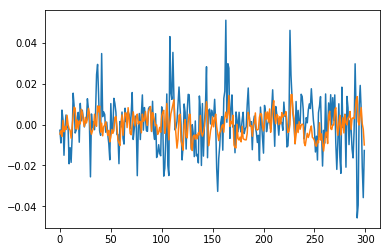

In [271]:
plt.plot(y_test)
plt.plot(y_pred)

In [264]:
comparison_change = pd.concat([pd.DataFrame(y_test.reshape((-1, 1))), 
                        pd.DataFrame(y_pred.reshape((-1, 1)))], axis=1)

# Calculate the pct change    
comparison_change.columns = ["True", "Pred"]

# Tranform regression predictions to classification
test = []
for a in comparison_change["True"]:
    if a >= 0:
        test.append(1)
    else:
        test.append(0)

pred = []
for a in comparison_change["Pred"]:
    if a >= 0:
        pred.append(1)
    else:
        pred.append(0)


In [265]:
# Classification Report
print(classification_report(test, pred))

              precision    recall  f1-score   support

           0       0.59      0.18      0.28       133
           1       0.58      0.90      0.70       167

    accuracy                           0.58       300
   macro avg       0.58      0.54      0.49       300
weighted avg       0.58      0.58      0.51       300



In [179]:
keras.__version__

'2.2.4-tf'